# **Libraries.**


In [1]:
'''
    Import related libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy.special
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad
from sklearn.metrics import mean_squared_error
from PIL import Image
from google.colab import files
from IPython.display import Markdown, display
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FuncFormatter, LogLocator
import matplotlib.dates as mdates


# **Import files.**


In [2]:
'''
   Upload and read files'''
uploaded = files.upload(); # Upload command
choosefiles = list(uploaded.keys()); # Choose files

'''
   Store and read data frames'''
# Empty lists to store dataframes and file names//
dfs = []; # To store dataframes from uploaded files.
file_names = []; # To store file names.

# Load all uploaded files and their data//
for file_name in choosefiles:
    xls = pd.ExcelFile(file_name); # Open Excel file and inspect its contents.
    df = pd.read_excel(file_name, sheet_name=xls.sheet_names[0]); # Read sheet into a pandas dataframe.
    dfs.append(df); # Store the dataframe.
    file_names.append(file_name); # Store the file names.

    # Print the first few rows of each file//
    print(f"First few lines of {file_name}:");
    print(df.head()); # Display the first 5 rows of the dataframe.
    print("\n" + "="*50 + "\n"); # Separator for clarity.


Saving x = 0 mm.xlsx to x = 0 mm.xlsx
Saving x = 7.79475 mm.xlsx to x = 7.79475 mm.xlsx
Saving x = 12.86946 mm.xlsx to x = 12.86946 mm.xlsx
Saving x = 17.90498 mm.xlsx to x = 17.90498 mm.xlsx
Saving x = 23.07683 mm.xlsx to x = 23.07683 mm.xlsx
Saving x = 27.48345 mm.xlsx to x = 27.48345 mm.xlsx
Saving x = 32.9586 mm.xlsx to x = 32.9586 mm.xlsx
Saving x = 37.681 mm.xlsx to x = 37.681 mm.xlsx
Saving x = 42.79084 mm.xlsx to x = 42.79084 mm.xlsx
Saving x = 47.84624 mm.xlsx to x = 47.84624 mm.xlsx
Saving x = 52.68388 mm.xlsx to x = 52.68388 mm.xlsx
Saving x = 57.00472 mm.xlsx to x = 57.00472 mm.xlsx
First few lines of x = 0 mm.xlsx:
                     Unnamed: 0        Unnamed: 1  Unnamed: 2  Unnamed: 3  \
0  Temperatures, d = 0.00000 mm               NaN         NaN         NaN   
1                           NaN  T (K) at t (min)         NaN         NaN   
2                         P (W)                 1    2.000000    3.000000   
3                           0.1        294.436555  294.6

# **Process data files.**


In [3]:
'''
   Process and arrange data'''
def process_file(file_path, x_value):
    # Load the file//
    df = pd.read_excel(file_path, skiprows=2); # Skip metadata rows.
    df.columns = df.iloc[0]; # Set the first row as column headers.
    df = df[1:]; # Drop the first row.

    # Clean up the dataframe//
    df = df.rename(columns={df.columns[0]: 'P (W)'}).reset_index(drop=True);
    df = df.dropna(axis=1, how='all'); # Remove entirely empty columns.
    df = df.dropna(axis=0, how='all'); # Remove entirely empty rows.

    # Melt the dataframe to long format//
    df_melted = df.melt(id_vars=['P (W)'], var_name='t (min)', value_name='Temperature (K)');
    df_melted['x (mm)'] = x_value; # Add the x value to the dataframe.
    return df_melted

'''
   Combining data from multiple files'''
# Arrange files based on the x_positions//
x_positions = [0, 7.79475, 12.86946, 17.90498, 23.07683, 27.48345, 32.9586,
               37.681, 42.79084, 47.84624, 52.68388, 57.00472];

# Process all files and combine into one dataset//
processed_dataframes = [];
for file, x in zip(file_names, x_positions): # Combines each file path with the corresponding x-position.
    processed_df = process_file(file, x); # Process the data for each file.
    processed_dataframes.append(processed_df); # Processed data for each file is appended to the list.

# Combine all processed dataframes//
combined_data = pd.concat(processed_dataframes, ignore_index=True); # Concatenates all the processed dataframmes into a single dataframe.

# Rearrange columns to show in the order of x, P, t, T//
rearrange_combined_data = combined_data[['x (mm)', 'P (W)', 't (min)', 'Temperature (K)']];

# Print the processed data in sequence of (x, P, t, T)//
print("Processed Temperature Data in Sequence (x, P, t, T):");
print(rearrange_combined_data);

'''
   Prepare data for analysis'''
x_values = rearrange_combined_data['x (mm)'].astype(float).values;
P_values = rearrange_combined_data['P (W)'].astype(float).values;
t_values = rearrange_combined_data['t (min)'].astype(float).values;
temperature_values = rearrange_combined_data['Temperature (K)'].astype(float).values;
coords = (x_values, P_values, t_values); # Combine ndependent variables into a tuple for analysis.


Processed Temperature Data in Sequence (x, P, t, T):
        x (mm)  P (W) t (min)  Temperature (K)
0      0.00000    0.1     1.0       294.436555
1      0.00000    0.6     1.0       300.853524
2      0.00000    1.5     1.0       312.365388
3      0.00000    2.4     1.0       323.833002
4      0.00000      4     1.0       344.113860
...        ...    ...     ...              ...
3055  57.00472  20.16    15.0       300.632005
3056  57.00472  21.66    15.0       301.427982
3057  57.00472   23.2    15.0       302.266051
3058  57.00472   23.6    15.0       302.487068
3059  57.00472     24    15.0       302.710251

[3060 rows x 4 columns]


# **Calculate $R^2$.**


In [4]:
'''
   Define function'''
def calculate_r2(coords, temperature_values, model, coeffs):
    predicted_values = model(coords, *coeffs); # Caclulate predicted value.
    residuals = (temperature_values - predicted_values); # Calculate residuals.
    ss_res = np.sum(residuals**2); # Calculate residual sum of squares.
    ss_tot = (np.sum((temperature_values - np.mean(temperature_values))**2)); # Caclaulte total sum of squares.
    r2 = (1 - (ss_res / ss_tot));
    return (r2);


# **Case. 1 Polynomial models (without interactions).**


In [5]:
'''
   Define function for (without interactions case)'''
def calculate_r2_withoutinteractions(max_order, coords, temperature_values):
    r2_withoutinteractions = []; # Function definition and initialization.
    for order in range(1, max_order + 1):

        # Without interaction model definition//
        def without_interaction_model(coords, *coeffs):
            x, P, t = coords;
            total = coeffs[0]; # Intercept.
            index = 1;

            # Defining non-interaction terms//
            for i in range(1, order + 1):
                total += coeffs[index] * x**i;
                index += 1;
                total += coeffs[index] * P**i;
                index += 1;
                total += coeffs[index] * t**i;
                index += 1;
            return (total);

        # Calculate number of coefficients//
        num_coeffs = 1 + 3 * order; # Intercept + terms per variable.
        try:
            # Fit the model using curve fit//
            popt_dynamic, _ = curve_fit(without_interaction_model, coords,
                                        temperature_values, p0=[0] * num_coeffs, maxfev=30000);
            # Calculate R² for the fitted model//
            r2_without_interaction_model = calculate_r2(coords, temperature_values, without_interaction_model, popt_dynamic);
            r2_withoutinteractions.append(r2_without_interaction_model);
        except RuntimeError:
            r2_withoutinteractions.append(None);
    return (r2_withoutinteractions); # Return R² values.


# **Case. 2 Polynomial models (with interactions).**


In [6]:
'''
   Define function for (with interactions case)'''
def calculate_r2_with_interactions(max_order, coords, temperature_values):
    r2_with_interactions = []; # Function definition and initialization.
    for order in range(1, max_order + 1):

        # Interaction model definition//
        def interaction_model(coords, *coeffs):
            x, P, t = coords;
            total = coeffs[0]; # Intercept.
            index = 1;

            # Defining non-interaction terms for this case//
            for i in range(1, order + 1):
                total += coeffs[index] * x**i;
                index += 1;
                total += coeffs[index] * P**i;
                index += 1;
                total += coeffs[index] * t**i;
                index += 1;

                # Defining interaction terms//
                for j in range(1, i + 1):
                    total += coeffs[index] * x**j * P**(i - j);
                    index += 1;
                    total += coeffs[index] * x**j * t**(i - j);
                    index += 1;
                    total += coeffs[index] * P**j * t**(i - j);
                    index += 1;
            return (total);

        # Calculate number of coefficients//
        num_coeffs = 1 + 3 * order + 3 * sum(range(1, order + 1));
        try:

            # Fit the model using curve fit//
            popt_interaction, _ = curve_fit(interaction_model, coords,
                                            temperature_values, p0=[0] * num_coeffs, maxfev=30000);

            # Calculate R² for the Fitted Model//
            r2_interaction = calculate_r2(coords, temperature_values, interaction_model, popt_interaction);
            r2_with_interactions.append(r2_interaction);
        except RuntimeError:
            r2_with_interactions.append(None);
    return (r2_with_interactions); # Return R² values.


# **C$_{\mathrm{jkl}}$ vs n.**


In [7]:
'''
   Define'''
def calculate_number_of_terms(max_order):
    terms_without_interactions = [];
    terms_with_interactions = [];

    for order in range(1, max_order + 1):
        terms_no_interaction = 1 + 3 * order;
        interaction_terms = 3 * sum(range(1, order + 1));
        terms_without_interactions.append(terms_no_interaction);
        terms_with_interactions.append(terms_no_interaction + interaction_terms);

    return (terms_without_interactions, terms_with_interactions);


# **Plot-1.**


In [8]:
'''
   For Execution'''
max_order = 6; # Select order.
r2_interactions_NO = calculate_r2_withoutinteractions(max_order, coords, temperature_values);
r2_interactions_YES = calculate_r2_with_interactions(max_order, coords, temperature_values);
terms_without_interactions, terms_with_interactions = calculate_number_of_terms(max_order);


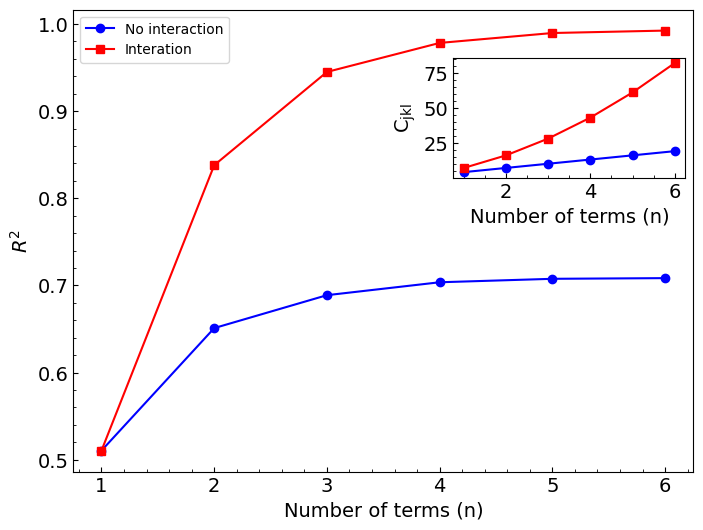

In [9]:

'''
   Plot'''
fig, ax_main = plt.subplots(figsize=(8, 6));

'''
    Main plot: R² values'''
ax_main.plot(range(1, max_order + 1), r2_interactions_NO, marker='o', label='No interaction', color='blue');
ax_main.plot(range(1, max_order + 1), r2_interactions_YES, marker='s', label='Interation', color='red');

# For X and Y axis labeling//
ax_main.set_xlabel(r'Number of terms (n)', fontsize=14);
ax_main.set_ylabel(r'$R^2$', alpha=1, fontsize=14);

# For axis limits//
#ax_main.set_xlim(np.min(max_order), np.max(max_order));
#ax_main.set_ylim(0, 80);

# For x-and y-axis major(minor) ticks
ax_main.tick_params(which="both", axis="x", direction="in", bottom=True, top=False, labelsize = 14);
ax_main.tick_params(which="both", axis="y", direction="in", left=True, right=False, labelsize = 14);

# For x-and y-axis minor ticks locator
ax_main.xaxis.set_minor_locator(AutoMinorLocator());
ax_main.yaxis.set_minor_locator(AutoMinorLocator());

'''
    Inset plot: Number of terms'''
#ax_inset = inset_axes(ax_main, width="70%", height="50%", loc="upper left");
ax_inset = fig.add_axes([0.60, 0.6, 0.29, 0.20]); # Position inset [left, bottom, width, height];
ax_inset.plot(range(1, max_order + 1), terms_without_interactions, marker='o', color='blue');
ax_inset.plot(range(1, max_order + 1), terms_with_interactions, marker='s', color='red');

# For X and Y axis labeling//
ax_inset.set_xlabel(r'Number of terms (n)', fontsize=14);
ax_inset.set_ylabel(r'C$_{\mathrm{jkl}}$', alpha=1, fontsize=14
                );

# X and Y axis major(minor) ticks//
ax_inset.tick_params(which="both", axis="x", direction="in", bottom=True, top=False, labelsize=14);
ax_inset.tick_params(which="both", axis="y", direction="in", left=True, right=False, labelsize=14);

# Minor ticks locator//
ax_inset.xaxis.set_minor_locator(AutoMinorLocator());
ax_inset.yaxis.set_minor_locator(AutoMinorLocator());

# Legend
ax_main.legend(loc='upper left', fontsize=10);
plt.show();


# **Plot-2.**


In [10]:
############################################## Section - 1 ##############################################
# Calculate R^2//
def calculate_r2(coords, temperature_values, model, coeffs):
    predicted_values = model(coords, *coeffs);
    residuals = (temperature_values - predicted_values);
    ss_res = np.sum(residuals**2);
    ss_tot = (np.sum((temperature_values - np.mean(temperature_values))**2));
    r2 = (1 - (ss_res / ss_tot));
    return (r2, predicted_values);

# Polynomial Models Without Interactions//
def fit_polynomial_without_interactions(order, coords, temperature_values):
    def model(coords, *coeffs):
        x, P, t = coords;
        total = coeffs[0]; # Intercept.
        index = 1;
        for i in range(1, order + 1):
            total += coeffs[index] * x**i;
            index += 1;
            total += coeffs[index] * P**i;
            index += 1;
            total += coeffs[index] * t**i;
            index += 1;
        return (total);

    num_coeffs = 1 + 3 * order; # Intercept + terms per variable.
    popt, _ = curve_fit(model, coords, temperature_values, p0=[0] * num_coeffs, maxfev=30000);
    r2, predictions = calculate_r2(coords, temperature_values, model, popt);
    return (r2, predictions);

# Polynomial Models With Interactions//
def fit_polynomial_with_interactions(order, coords, temperature_values):
    def model(coords, *coeffs):
        x, P, t = coords;
        total = coeffs[0]; # Intercept.
        index = 1;
        for i in range(1, order + 1):
            total += coeffs[index] * x**i;
            index += 1;
            total += coeffs[index] * P**i;
            index += 1;
            total += coeffs[index] * t**i;
            index += 1;
            for j in range(1, i + 1):
                total += coeffs[index] * x**j * P**(i - j);
                index += 1;
                total += coeffs[index] * x**j * t**(i - j);
                index += 1;
                total += coeffs[index] * P**j * t**(i - j);
                index += 1;
        return (total);

    num_coeffs = (1 + 3 * order + 3 * sum(range(1, order + 1)));
    popt, _ = curve_fit(model, coords, temperature_values, p0=[0] * num_coeffs, maxfev=30000);
    r2, predictions = calculate_r2(coords, temperature_values, model, popt);
    return (r2, predictions);

############################################## Section - 2 ##############################################
# Execution Example//
r2_without, predictions_without = fit_polynomial_without_interactions(max_order, coords, temperature_values)
r2_with, predictions_with = fit_polynomial_with_interactions(max_order, coords, temperature_values)
num_points = len(temperature_values); print(f"Number of Temperature Points Used in Plot: {num_points}");

Number of Temperature Points Used in Plot: 3060


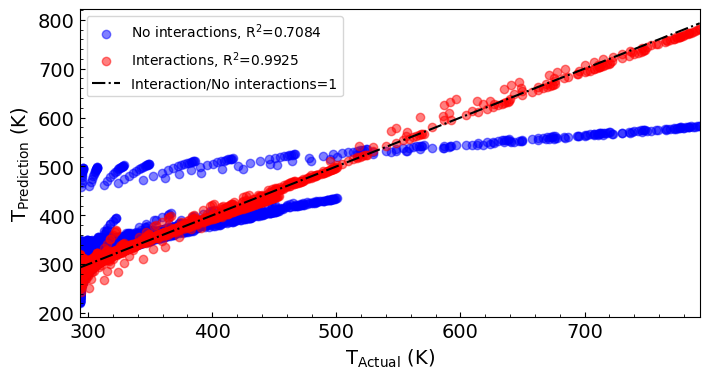

In [11]:
############################################## Section - 3 ##############################################
fig, ax_main = plt.subplots(figsize=(8, 4));

ax_main.scatter(temperature_values, predictions_without, alpha=0.5, label= 'No interactions, R$^2$={:.4f}'.format(r2_without),
    color='blue');
ax_main.scatter(temperature_values, predictions_with, alpha=0.5, label= 'Interactions, R$^2$={:.4f}'.format(r2_with),
    color='red');
ax_main.plot([min(temperature_values), max(temperature_values)], [min(temperature_values), max(temperature_values)], 'k-.', label='Interaction/No interactions=1');

# For X and Y axis labeling//
ax_main.set_xlabel(r'T$_{\mathrm{Actual}}$ (K)', alpha=1, fontsize=14);
ax_main.set_ylabel(r'T$_{\mathrm{Prediction}}$ (K)', alpha=1, fontsize=14);

# For axis limits//
ax_main.set_xlim(np.min(temperature_values), np.max(temperature_values));
#ax_main.set_ylim(0, 80);

# For x-and y-axis major(minor) ticks
ax_main.tick_params(which="both", axis="x", direction="in", bottom=True, top=False, labelsize = 14);
ax_main.tick_params(which="both", axis="y", direction="in", left=True, right=False, labelsize = 14);

# For x-and y-axis minor ticks locator
ax_main.xaxis.set_minor_locator(AutoMinorLocator());
ax_main.yaxis.set_minor_locator(AutoMinorLocator());

# Legend
ax_main.legend(loc='upper left', fontsize=10);
plt.show();